# Neural Style Transfer using Mapbox API

Satellite imagery provides an interesting platform for style transfer. Its nearly two dimensional perspective and rich texture lends itself well to recieving many types of styles; and its content is something familiar to us, encouraging the eye to linger on the image and the changes that the style transfer has produced.

Mapbox's static images API provides a very convenient way for us to explore the world through the lens of a particular artistic style. We'll define interesting locations as [longitude, latitude, zoom], and then use the API to get images of those locations for style transfer.

In [1]:
import keras
import keras.backend as K
from keras import metrics
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Conv2D, AveragePooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape

from scipy.optimize import fmin_l_bfgs_b
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import requests
from PIL import Image
from io import BytesIO
from scipy.misc import imread, imresize, imsave, fromimage, toimage

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

Using TensorFlow backend.


In [2]:
# file path to the style we want to use for transfer:
style_path = '../../imgs/ama/styles/tmp/4.jpg'

# Some cool locations:
mount_hood = '-121.982,45.497,9.6'
crater_lake = '-122.107,42.934,12'
brondby_haveby = '12.401,55.637,15.8'
durrat_bahrain = '50.603,25.836,13.8'

# request parameters for getting a mapbox sattelite image:
map_style = 'INSERT_STYLE_ID'
token = 'INSERT_MAPBOX_TOKEN'
location = mount_hood
resolution = '1200x1200'
request_url = "https://api.mapbox.com/styles/v1/"+map_style+"/static/"+location+"/"+resolution+"?access_token=" + token

# make the request and store the resulting image as a numpy array:
req = requests.get(request_url)
img_raw = Image.open(BytesIO(req.content))
img = np.array(img_raw)

# half size for speed:
img = imresize(img, 0.35)

# Style Transfer
I dont intend this to be a comprehensive lesson on style transfer, good examples of that have already been produced by [fast.ai](http://course.fast.ai/lessons/lesson8.html) and [arxiv papers](https://arxiv.org/abs/1605.04603) upon which this implementation is based.

The basic idea is that by exploring the activations of deep convolutions in an image classification network, we can seperate and extract the "style" of the image from the "content" of the image. Those can then be reused to apply a particular style to some other content by iteratively calculating a mean squared error loss between the new image and the original style, then updating the pixels of the image to account for this error (as if they were weights in a network).

We'll use the VGG16 network and the improvements suggested in the paper above by Novak and Nikulin

### Process and deprocess images for VGG
Original VGG ImageNet training used images that were mean centered on the ImageNet dataset, and were in BGR channel order. We need to apply these same steps to images we pass through it, and reverse them for images produced out of it.

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:,:, :, ::-1] + rn_mean, 0, 255).astype('uint8')

### Define some functions for working with our images

In [4]:
# resize the style image to match the content image w/ zoom and cropping:
def resize_style(img, style):
    if img.shape == style.shape: return style
    width_diff = img.shape[0] / style.shape[0]
    height_diff = img.shape[1] / style.shape[1]
    if width_diff >= height_diff:
        zoom_style = imresize(style, width_diff)
        return imresize(zoom_style[:,:img.shape[1]], img.shape)
    if height_diff >= width_diff:
        zoom_style = imresize(style, height_diff)
        return imresize(zoom_style[:img.shape[0],:], img.shape)

# preserve image color from original in the output image:
def original_color_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr
    generated[:, :, 1:] = content[:, :, 1:]  # Set CbCr equal              
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Back to RGB
    return generated

### Open up the style image and resize it to fit the content

In [5]:
style = np.array(Image.open(style_path))
style = resize_style(img, style)

Preprocess both images

In [6]:
img_proc = preproc(np.expand_dims(np.array(img), 0))
style_proc = preproc(np.expand_dims(np.array(style), 0))

In [7]:
shp = img_proc.shape

## Evaluator Class

We need an evaluator class to allow the sklearn optimizer to access loss and gradients seperately

In [8]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

## Loss functions

We have three loss functions, one for loss against original content, one for loss against the style, and one for variational loss in the final image

In [9]:
def content_loss(computed, target, shape):
    channels = 3
    size = shape[0] * shape[1]
#     multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))
    multiplier = 1
    return multiplier * K.sum(K.square(computed - target))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot((features - 1), K.transpose(features - 1))

def style_loss(computed, target, shape):
    S = gram_matrix(target)
    C = gram_matrix(computed)
    channels = 3
    size = shape[1] * shape[2]
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variational_loss(x, shape):
    none, width, height, depth = shape
    a = K.square(x[:, :width-1, :height-1, :] - x[:, 1:, :height-1, :])
    b = K.square(x[:, :width-1, :height-1, :] - x[:, :width-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Set up a tensor to hold the content, style, and output images

In [10]:
base_tensor = K.variable(img_proc)
style_tensor = K.variable(style_proc)
combination_image = K.placeholder(shp)

image_tensors = [base_tensor, style_tensor, combination_image]
num_tensors = len(image_tensors)
input_tensor = K.concatenate(image_tensors, axis=0)

## VGG Model

In [11]:
weights_path = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

input_shape = _obtain_input_shape((shp[1],shp[2],shp[3]),
                                  default_size=224,
                                  min_size=48,
                                  data_format=K.image_data_format(),
                                  require_flatten=False)

img_input = Input(tensor=input_tensor, shape=input_shape)

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

inputs = get_source_inputs(input_tensor)
model = Model(inputs, x, name='vgg16')

weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        weights_path,
                        cache_subdir='models')
model.load_weights(weights_path)

### Layer dictionary

In [12]:
layer_outputs = {l.name: (l.output, l.output_shape) for l in model.layers}

## Activations and layer outputs

In [13]:
feature_layers = ['block1_conv1','block1_conv2','block2_conv1','block2_conv2','block3_conv1',
                  'block3_conv2','block3_conv3','block4_conv1','block4_conv2','block4_conv3',
                  'block5_conv1','block5_conv2','block5_conv3']

style_layers = [layer_outputs[feature][0] for feature in feature_layers]
style_layer_shapes = [layer_outputs[feature][1] for feature in feature_layers]
num_layers = len(style_layers) - 1

content_layer = layer_outputs['block5_conv2'][0]
content_activations = content_layer[0, :, :, :]
content_computed = content_layer[num_tensors - 1, :, :, :]

### Network hyperparameters, experiment with these

In [14]:
style_scale = 100
style_weight = 1
content_weight = 0.125
variational_weight = 8.5e-5

## Loss calculations

In [15]:
# Content loss:
loss = content_weight * content_loss(content_computed, content_activations, shp)

# Style loss:
def partialLoss(layers, shapes, i):
    layer = layers[i]
    shape = shapes[i]
    layer_activations = layer[1, :, :, :]
    layer_computed = layer[2, :, :, :]
    partial_loss = style_loss(layer_computed, layer_activations, shape)
    return partial_loss

for i in range(num_layers):
    loss_one = partialLoss(style_layers, style_layer_shapes, i)
    loss_two = partialLoss(style_layers, style_layer_shapes, i + 1)
    layer_loss = loss_one - loss_two
    loss += (style_weight / (2 ** (num_layers - (i + 1)))) * layer_loss
    
# Variational Loss:
loss += variational_weight * total_variational_loss(combination_image, shp)

### Gradient of the loss on target image

In [16]:
grads = K.gradients(loss, combination_image)
# run loss and grads together
fn = K.function([combination_image], [loss] + grads)

## Optimize

In [17]:
def solve_image(eval_obj, epochs, x):
    for i in range(epochs):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Epoch %s | loss: %s' %(i, min_val))
    return x

In [18]:
evaluator = Evaluator(fn, shp)
target = img_proc.copy()
target = solve_image(evaluator, 10, target)

Epoch 0 | loss: 813640256.0
Epoch 1 | loss: 348184320.0
Epoch 2 | loss: 167763904.0
Epoch 3 | loss: 99749544.0
Epoch 4 | loss: 63431816.0
Epoch 5 | loss: 46449792.0
Epoch 6 | loss: 35521108.0
Epoch 7 | loss: 29411104.0
Epoch 8 | loss: 25366052.0
Epoch 9 | loss: 22082336.0


## View the result

In [19]:
def imprint_preserve(im):
    new_img = deproc(im, shp).astype('uint8')[0]
    converted_original = imresize(img_raw.convert('YCbCr'), (shp[1], shp[2]))
    preserved_img = original_color_transform(converted_original, new_img)
    plt.imshow(preserved_img)

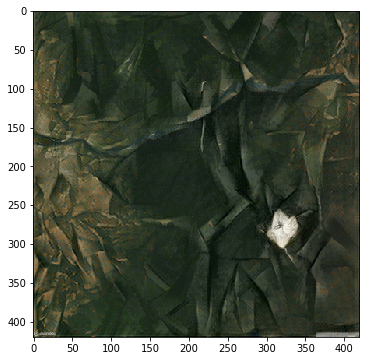

In [20]:
# Try color preservation
imprint_preserve(target)

## Save the image

In [21]:
def savePreserve(im, shape, name):
    new_img = deproc(im, shape).astype('uint8')[0]
    converted_original = imresize(img_raw.convert('YCbCr'), (shp[1], shp[2]))
    preserved_img = original_color_transform(converted_original, new_img)
    imsave('../../imgs/'+name, preserved_img)

In [23]:
savePreserve(target, shp, 'ama/hood_picasso_500_content.jpg')